In [90]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw7.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 7: Fairness and Bias


**Harvard University**<br/>
**Fall 2022**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2pt">

In [91]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [92]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, roc_auc_score
)                           
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib inline

<hr>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells. This is how the notebook will be evaluated (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<hr>

<a id="contents"></a>

## Notebook contents

- [**Required reading and data description**](#intro)


- [**Question 1: Data exploration [26 pts]**](#part1)


- [**Question 2: Baseline modeling [21 pts]**](#part2)


- [**Question 3: Predicting without using `race` [19 pts]**](#part3)


- [**Question 4: Classification thresholds and fairness [34 pts]**](#part4)

<a id="intro"></a>

## Required reading and data description

[Return to contents](#contents)

### Required reading

The required readings for this homework are two articles that report on the effectiveness of and issues surrounding the COMPAS recidivism algorithm used in U.S. courts. One article is published by ProPublica and the other by the MIT Technology Review:

1. Angwin, Julia; Larson, Jeff; Mattu, Surya; Kirchner, Lauren (2016). "Machine Bias: There’s software used across the country to predict future criminals. And it’s biased against blacks." ProPublica, May 23, 2016. https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


2. Hao, Karen; Stray, Jonathan (2019). "Can you make AI fairer than a judge? Play our courtroom algorithm game: The US criminal legal system uses predictive algorithms to try to make the judicial process less biased. But there’s a deeper problem." MIT Technology Review, October 17, 2019. https://www.technologyreview.com/2019/10/17/75285/ai-fairer-than-judge-criminal-risk-assessment-algorithm/

You will need to read these articles for the sufficient background needed to successfully complete this homework assignment. It may also be useful to refer back to content covered during the mid-semester lecture on ethics: [Lecture 11: EthiCS](https://edstem.org/us/courses/26506/lessons/46044/slides/263725).

### Data description

In this assignment, we will be analyzing a portion of the data set used by ProPublica in their report. The data are found in the `compas.csv` file and the "data dictionary", which very briefly explains each variable in the data set, can be found in the `compas_datadict.csv` file.

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration [26 pts]</div> 
    
[Return to contents](#contents)

The code provided below will load, preprocess, and split the COMPAS data into train and test sets for you.

In [93]:
# Read in the data
compas_df = pd.read_csv("data/compas.csv")

# Inspect the original dataframe shape
print(
    "Prior to processing our data, the original COMPAS dataframe was "
    "shape:\n\n\t{}\n\nAnd, these were the first several observations:"
    .format(compas_df.shape)
)

# Inspect original a few observations prior to processing the attributes
display(compas_df.head())

# Process binary categorical variables
compas_df["sex"] = (compas_df["sex"] == "Male").astype(int)

# print(compas_df["c_charge_degree"].value_counts())
compas_df["felony"] = (compas_df["c_charge_degree"] == "F").astype(int)

# One-hot-encode the race variable
one_hot_df = pd.get_dummies(
    compas_df["race"], prefix="race", drop_first=False
)
compas_race_df = pd.concat(
    [compas_df.drop("race", axis=1), one_hot_df], axis=1
)

# Drop the categorical variables and leave n-1 race columns
compas_race_df = compas_race_df.drop(
    [
        "c_charge_degree",
        "c_charge_desc",
        "score_text",
        "race_Other",
    ],
    axis=1,
)

# Make 80-20 train-test split, stratifying on race
train_df, test_df = train_test_split(
    compas_race_df,
    train_size=0.8,
    stratify=compas_df["race"],
    random_state=50,
)

# Inspect training dataframe after processing and splitting the data
print(
    "\n\nAfter processing and splitting our data, our training and test"
    " data were of the shapes:\n\n\t{}\t{}\n\nAnd, these were the first"
    " several observations of the training set:"
    .format(train_df.shape, test_df.shape)
)
display(train_df.head())

Prior to processing our data, the original COMPAS dataframe was shape:

	(6172, 23)

And, these were the first several observations:


,age,c_charge_degree,c_charge_desc,race,score_text,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,...,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
0,69,F,Aggravated Assault w/Firearm,Other,Low,Male,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,34,F,Felony Battery w/Prior Convict,African-American,Low,Male,0,0,0,0,...,0,0,0,0,0,0,0,1,0,10
2,24,F,Possession of Cocaine,African-American,Low,Male,4,0,0,1,...,0,1,0,0,0,1,1,0,0,1
3,44,M,Battery,Other,Low,Male,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,41,F,Possession Burglary Tools,Caucasian,Medium,Male,14,0,0,0,...,0,0,1,0,0,0,0,0,1,6




After processing and splitting our data, our training and test data were of the shapes:

	(4937, 25)	(1235, 25)

And, these were the first several observations of the training set:


,age,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,...,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh,felony,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American
5468,21,1,1,1,0,2,10,1,2,1,...,0,0,0,2,1,1,0,0,0,0
3550,57,1,0,0,0,0,1,0,1,0,...,0,1,0,1,0,1,0,0,0,0
5882,23,0,2,0,0,0,7,1,1,0,...,0,0,0,1,0,1,0,0,0,0
2982,32,0,2,0,0,0,10,1,33,0,...,1,0,0,30,1,0,0,1,0,0
5160,25,1,1,0,0,0,4,1,2,1,...,1,0,0,2,1,0,0,0,0,0


<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.1** What is the statistical objective of the COMPAS algorithm?  How is recidivism prediction used in courtrooms?

</div>

_Points:_ 7

_The __statistical__ objective of Correctional Offender Management Profiling for Alternative Sanctions (COMPAS) was to predict a defendant's risk of recidivating based on 137 questions. Risk is the response variable and there are 137 predictors._

_Of their own accord, and contrary to the original intent of the statistician who designed the algorithm, judges have begun using COMPAS as an input to determine sentence lengths. (Though this is hardly the first misuse of data and statistics by non-specialists, let it stand as yet another warning to our profession.)_

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.2** Use the information in the provided `compas_datadict.csv` to answer the following question about the variables in the dataset:
    
* Which variables are raw data?  Which are pre-processed data? Justify your answer.
* Which is the target variable of the COMPAS algorithm?
* Which are output(s) of the COMPAS algorithm?
* Which should not be used in building our own model to predict recidivism? Why?

</div>

_Points:_ 6

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Raw or Pre-Processed?</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>age
      <th>Raw/objective
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>c_charge_degree
      <th>Raw/objective
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>race
      <th>Raw/objective
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>sex
      <th>Raw/objective
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>length_of_stay
      <th>Pre-processed (seems to be "often" a judge's guesstimate, and what is it the rest of the time? The arresting officer's estimate?)
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>length_of_stay_thresh
      <th>Dependent on length_of_stay so ipso facto also pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>priors_count
      <th>Extra-jurisdictional data might be compiled with human intervention depending on the remote jurisdiction, and thus pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>priors_1 
      <th>Dependent on priors_count so ipso facto also pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>priors_234
      <th>Dependent on priors_count so ipso facto also pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>priors_5plus
      <th>Dependent on priors_count so ipso facto also pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>juv_fel_count
      <th>Extra-jurisdictional data might be compiled with human intervention depending on the remote jurisdiction, and thus pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>juv_misd_count
      <th>Extra-jurisdictional data might be compiled with human intervention depending on the remote jurisdiction, and thus pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>juv_other_count
      <th>Extra-jurisdictional data might be compiled with human intervention depending on the remote jurisdiction, and thus pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>juv_fel_1plus
      <th>Dependent on juv_fel_1plus so ipso facto also pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>juv_misd_1plus
      <th>Dependent on juv_misd_1plus so ipso facto also pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>juv_other_1plus
      <th>Dependent on juv_other_1plus so ipso facto also pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>charge_any_drug
      <th>By definition, compiled with human intervention, and thus pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>charge_any_violence_aggression
      <th>By definition, compiled with human intervention, and thus pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>charge_any_theft
      <th>By definition, compiled with human intervention, and thus pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>c_charge_desc
      <th>By definition, compiled with human intervention; any derivative variables (and judge's interpretation thereof) are also pre-processed
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>score_text
      <th>Indicator variable of `two_year_recid` so pre-processed by derivation
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>decile_score
      <th>Indicator variable of `two_year_recid` so pre-processed by derivation
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>two_year_recid
      <th>This is the variable whose value is modeled and predicted by the 137 other variables
    </tr>
  </tbody>
</table>

* `two_year_recid` is the target variable, modeled and predicted by the 137 inputs to the COMPAS algorithm

* The most "distilled" output appears to be `score_text`. However, since we know from the ProPublica article that judges have access to `decile_score`, it appears that `score_text` and `decile_score` are both output(s) of the COMPAS algorithm. 

* To maximize objectivity and minimize any inputs that might result from court officers' conscious or subconscious biases, should avoid subjective or "best guess" variables and variables derived from subjective variables, like `length_of_stay`, `length_of_stay_thresh`, `charge_any_drug`, `charge_any_violence_aggression`, and `charge_any_theft` in building our own model to predict recidivism. 

* We should also be wary of variables that come from remote jurisdictions, which tend to vary in accuracy and thus compromise predictive accuracy.

* Finally, we should consider eliminating other variables from among the 137 that might correlate in the "associational infrastructure" with _any_ legally protected, socially constructed, or intersectionally disadvantaged class--most prominently `race`, but also `sex`. Moreover, ethnicity, religion, gender identity/sexual orientation, and perceived economic status (past or present), among factors, might influence the subjective variables `charge_any_drug`, `charge_any_violence_aggression`, and `charge_any_theft`.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Now we will do a little EDA. Code has been provided to generate a visualization that explores which **unprocessed** quantitative variables, including `decile_score` (**not** the derived binary variables or pre-processed versions of the available quantitative variables, for example), are related to `race`. Feel free to create additional plots of your own if you like.

Based on the visualization(s), report which 3 variables appear to have the most significant differences between Caucasians and African Americans. Briefly interpret your findings for each of those 3 variables, being certain to explain your justification for choosing each.

**NOTE:** As illustrated by [the required readings](#intro), reporting on the U.S. Criminal Justice system often concentrates on the disparate experiences between Caucasians and African Americans, thus we have focused our approaches similarly. However, to ensure the efficacy of our models in Question 2 and Question 3, we must be certain to still keep observations for all racial groups included in our data. 
</div>

_Points:_ 7

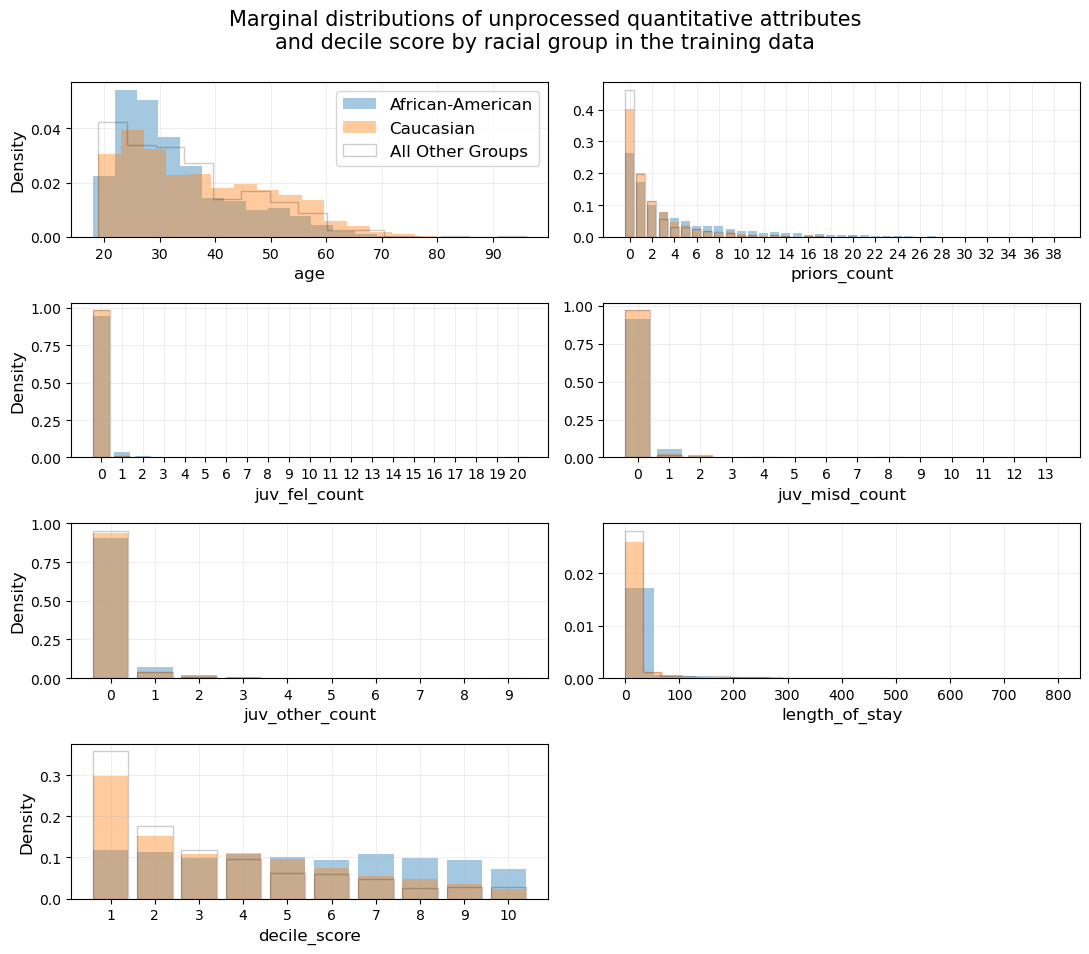

In [94]:
# List of unprocessed variables and decile score (e.g.,
# should not include any that are pre-processed in
# compas.csv)
chosen_cols = [
    "age",
    "priors_count",
    "juv_fel_count",
    "juv_misd_count",
    "juv_other_count",
    "length_of_stay",
    "decile_score"
]

# Generate indices for subsetting data based on racial group
aa_idx_train = np.where(train_df["race_African-American"]==1)[0]
cc_idx_train = np.where(train_df["race_Caucasian"]==1)[0]
non_aa_cc_idx_train = np.where(
    np.all(
        [
            train_df["race_Caucasian"]==0,
            train_df["race_African-American"]==0
        ],
        axis=0
    )
)[0]

# Generate plots as required
fig, axes = plt.subplots(4, 2, figsize=(11, 9.5))

labels = ["African-American", "Caucasian", "All Other Groups"]
indices = [aa_idx_train, cc_idx_train, non_aa_cc_idx_train]
colors = ["tab:blue", "tab:orange", "none"]
edgecolors = ["none", "none", "k"]
alphas = [0.4, 0.4, 0.2]

plt.suptitle(
    "Marginal distributions of unprocessed quantitative attributes\n"
    "and decile score by racial group in the training data",
    fontsize=15,
    y=1,
)

for i, (col, ax) in enumerate(zip(chosen_cols, axes.flatten())):
    for j, (idx, label, color, alpha, edgecolor) in enumerate(
        zip(indices, labels, colors, alphas, edgecolors)
    ):

        min_val = train_df[col].min()
        max_val = train_df[col].max()
        
        # Plot as barplot if variable has small range of discrete values
        if max_val < 40:
            n_obs = len(idx) 
            val_counts = train_df[col].iloc[idx].value_counts()
            vals = val_counts.index
            counts = val_counts.values
            ax.bar(
                vals,
                counts / n_obs,
                alpha=alpha,
                label=label,
                color=color,
                edgecolor=edgecolor,
            )
            ax.set_xticks(
                range(min_val, max_val+1) if max_val<=20
                else range(min_val, max_val+1, 2)
            )
        # Plot as histogram if sufficiently large range of values
        else:
            ax.hist(
                train_df[col].iloc[idx],
                alpha=alpha,
                label=label,
                color=color if not "none" else None,
                histtype="step" if color=="none" else "bar",
                edgecolor=edgecolor,
                density=True,
                bins=15,
            )
        if i%2==0:
            ax.set_ylabel("Density", fontsize=12)
        if i==0:
            ax.legend(fontsize=12)
        ax.set_xlabel(col, fontsize=12)
        ax.grid(":", alpha=0.2)
axes[3,1].axis("off")

plt.tight_layout()



DELETE: Based on the visualization(s), report which 3 variables appear to have the most significant differences between Caucasians and African Americans. Briefly interpret your findings for each of those 3 variables, being certain to explain your justification for choosing each.

* `age`: We see from the `age` histogram that at any `age=a`, the density tends to be greater over the interval `age<a` for African-Americans (and all other groups) than for Caucasians. Engagement with the criminal justice system appears to skew relatively younger for African-Americans and relatively older for Caucasians. The empirical history of police targeting of minorities implies a greater propensity for law enforcement to arbitrarily interpret similar behavior by a random representative of each racial category differently, being more likely to harass and pursue younger African-Americans while looking aside from identical conduct by younger Caucasians. The dissimilar distibutions of `age` might be causal of the dissimilar distributions of `priors_count`, discussed next:

* `priors_count`: We saw from the `age` histogram that at younger ages, a randomly-selected African-American is more likely to have encountered law enforcement at least once--though that difference in density appears to reverse over the interval `age>40` , and by age 60, the sum over the interval `age<60` appears to be approximately equivalent. (One possible cause of this apparent reversal might simply be that more older black than white individuals, who might otherwise still be subject to police harassment, are already serving lengthy prison sentences so _can't_ be re-arrested.) Since most encounters with law enforcement for both groups tend to happen at `age<40`, it stands to reason that a randomly selected African-American will also have a greater number of priors, likely accounting for the different density distributions in the  `priors_count` histogram.

* `decile_score`: Not only is the histographic density of this derivative response variable glaringly obvious to the eye; the shapes of the density distributions are entirely different. If curves were drawn across the tops of both histograms, the Caucasian distribution would appear asymptotic nearly to zero as risk approaches the maximum decile. The supposed risk of African-Americans recidivating, in contrast, appears nearly flat across all deciles. The imbalance that is visible in the overlapping histograms does not appear to coincide with empirical data, wherein re-arrest proportions are similar between the two groups at any given `decile_score`.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.4** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?

</div>

_Points:_ 6

_As explained in Q1.3, there appears to be a relationship between `age` and `priors_count`. Since more African-Americans than Caucasians have encountered the criminal justice system in their 20s, it follows that African-Americans in their 30s or older are likely to have more priors than Caucasians at the same age. Thus `age` and `priors_count` are likely correlated with one another. Since `age` is known to be empirically correlated with race, it follows that `priors_count` will also be correlated with race... and therefore introduces racial bias.
Likewise, if `age` and `priors_count` are correlated with race (given that the root cause is police targeting minority communities), the `decile_score`, which is partly calculated from `age` and `priors_count`, is likely to inherit the same bias. Finally, bias in the data would impact `length_of_stay` as this variable is influenced by the judge's decision of whether the defendant is at risk of recidivating._

_There appears to be bias against African-Americans as it has caused a tendency for African-Americans to have a higher decile score than any other group._

<!-- END QUESTION -->

---

<a id="part2"></a>

## <div class="exercise">Question 2: Baseline modeling [21 pts]</div> 
    
[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.1**  In this section we train a well-tuned, $LASSO$-like regularized logistic regression model to predict recidivism (i.e. `two_year_recid` is your response variable). We'll use the following predictors: `age`, `priors_1`, `priors_234`, `priors_5plus`, `juv_fel_1plus`, `juv_misd_1plus`, `juv_other_1plus`, `charge_any_drug`, `charge_any_violence_aggression`, `charge_any_theft`, as well as the one-hot-encoded predictors for `c_charge_degree`, `sex`, and `race`. 
    
Inspect the resulting coefficients and interpret what this model is saying about the relationship of `two_year_recid` to `race`.

</div>

_Points:_ 10

In [95]:
# Separate predictors and response
predictor_list = [
    "age",
    "sex",
    "priors_1",
    "priors_234",
    "priors_5plus",
    "juv_fel_1plus",
    "juv_misd_1plus",
    "juv_other_1plus",
    "charge_any_drug",
    "charge_any_violence_aggression",
    "charge_any_theft",
    "felony",
    "race_African-American",
    "race_Asian",
    "race_Caucasian",
    "race_Hispanic",
    "race_Native American",
]

response_var = "two_year_recid"

X_train = train_df[predictor_list]
X_test = test_df[predictor_list]

y_train = train_df[response_var].values
y_test = test_df[response_var].values

# Inspect shape of resulting design matrix
print(
    "The shapes of our resulting X and y train and test sets "
    "are:\n\n\tX_train\t{}\n\ty_train\t{}\n\n\tX_test\t{}\n\t"
    "y_test\t{}\n".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape,
    )
)

# Scale data to X_train, this is required for regularization
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the model
logit_model = LogisticRegressionCV(
    penalty="l1",
    solver="liblinear",
    max_iter=1000,
    random_state=109,
)
logit_model.fit(X_train_scaled, y_train)

# Print Coefficients
print(
    "The coefficients for the logistic regression model are:"
)
display(
    pd.DataFrame(
        index=["intercept"] + list(X_train.columns),
        data={
            "coefficients": np.hstack(
                [logit_model.intercept_, logit_model.coef_[0]]
            )
        },
    )
)

The shapes of our resulting X and y train and test sets are:

	X_train	(4937, 17)
	y_train	(4937,)

	X_test	(1235, 17)
	y_test	(1235,)

The coefficients for the logistic regression model are:


,coefficients
intercept,-0.403437
age,-2.203538
sex,0.057534
priors_1,0.022000
priors_234,0.556439
priors_5plus,1.364108
juv_fel_1plus,0.000000
juv_misd_1plus,0.000000
juv_other_1plus,0.418147
charge_any_drug,0.110054


_The LASSO regression process uses shrinkage to reduce coefficients in a linear regression model, usually reducing some coefficients all the way down to $0$ and effectively removing those coefficients from predicition calculations. We already noted in Q1 that African-Americans are more likely to have priors, and the possibility that police behavior is a signficant cause. This LASSO model predicts a greater likelihood of recidivism for an randomly selected African-American than a randomly selected individual of any other racial group of the same `age` and `sex`, even if both individuals have no priors!_

_Let us state this in a different way: given two individuals (one black) whose $x_i$s for all non-zero LASSO coefficients dealing with legal history, including `priors_1`, `priors_234`, `priors_5plus`, `juv_other_1plus`, `charge_any_drug`, `charge_any_theft`, and `felony` are equal to one another (or $x_i=0$ for all coefficients), this model will predict a higher probability of recidivism for the African-American person._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.2**  The code provided below reports the following metrics on the **test set**:

1. **Overall model accuracy score**


2. **False positive rates (FPR)** for each of the two groups (please note that a "positive" here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
    
3. **False negative rates (FNR)** for each of the two groups:
    - `African-American`
    - `Caucasian`

4. **Ratios of error rates**:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups
    - These ratios can be expressed as:

$$\frac{FPR(AA)}{FPR(CC)} \; \text{and} \; \frac{FNR(AA)}{FNR(CC)}$$


What do you observe? Is there any disparity in the $FPR$ and $FNR$ for the two groups? What are the implications of your findings? Explain your findings in 3-6 sentences.

</div>

_Points:_ 11

In [96]:
# Function to report required metric by model in Q2.2 and Q3.2
def evaluate_model(model, X_values, y_true, aa_idx, cc_idx):
    """Generate accuracy and error rate metrics for model
    
    Generates a set of test metrics for an input model, including
    model accuracy, FPR and FNR for both African-American and
    Caucasian racial groups, as well as FPR and FNR ratios
    defined as FPR(AfAm)/FPR(Caucasion) and 
    FNR(AfAm)/FNR(Caucasion)
    
    :param model: estimator, fitted scikit-learn classification
                  estimator such as LogisticRegression,
                  DecisionTreeClassifier, etc.
    :param X_values: np.ndarray, X matrix containing observations
                   for prediction and evaluation
    :param y_true: np.ndarray, true response classes
                   corresponding to each observation in the X
                   matrix
    :param aa_idx: np.ndarray, array of indices corresponding to
                   each African-American observation in the X
                   matrix
    :param cc_idx: np.ndarray, array of indices corresponding to
                   each Caucasion observation in the X matrix
    :returns: dict, resulting metrics including model accuracy,
              FPR and FNR for both African-American and Caucasian
              racial groups, as well as FPR and FNR ratios
    """
    y_pred = model.predict(X_values)
    model_accuracy = model.score(X_values, y_true)

    confusion_afam = dict(
        zip(
            ["tn","fp","fn","tp"],
            confusion_matrix(
                y_true[aa_idx], y_pred[aa_idx]
            ).ravel(),
        )
    )
    confusion_caucasian = dict(
        zip(
            ["tn","fp","fn","tp"],
            confusion_matrix(
                y_true[cc_idx], y_pred[cc_idx]
            ).ravel(),
        )
    )

    fpr_afam = (
        confusion_afam["fp"] / (
            confusion_afam["fp"] + confusion_afam["tn"]
        )
    )
    fnr_afam = (
        confusion_afam["fn"] / (
            confusion_afam["fn"] + confusion_afam["tp"]
        )
    )

    fpr_caucasian = (
        confusion_caucasian["fp"] / (
            confusion_caucasian["fp"] + confusion_caucasian["tn"]
        )
    )
    fnr_caucasian = (
        confusion_caucasian["fn"] / (
            confusion_caucasian["fn"] + confusion_caucasian["tp"]
        )
    )
    
    fpr_ratio = fpr_afam/fpr_caucasian
    fnr_ratio = fnr_afam/fnr_caucasian

    return dict(
        zip(
            [
                "Model Accuracy",
                "FPR African-American",
                "FNR African-American",
                "FPR Caucasian",
                "FNR Caucasian",
                "FPR Ratio",
                "FNR Ratio"
            ],
            [
                model_accuracy,
                fpr_afam,
                fnr_afam,
                fpr_caucasian,
                fnr_caucasian,
                fpr_ratio,
                fnr_ratio
            ],
        )
    )

In [97]:
# Save the indices for each of the two races on the test set
aa_idx_test = np.where(test_df["race_African-American"]==1)[0]
cc_idx_test = np.where(test_df["race_Caucasian"]==1)[0]

results_logit_model = evaluate_model(
    logit_model,
    X_test_scaled,
    y_test,
    aa_idx_test,
    cc_idx_test,
)
print(
    "The accuracy and error rates for the model on the "
    "test set are:\n\n\t\t\tmodel with race\n"
)
    
for key, value in results_logit_model.items():
    print(f"{key:20}\t{value:.4f}")

The accuracy and error rates for the model on the test set are:

			model with race

Model Accuracy      	0.6696
FPR African-American	0.3398
FNR African-American	0.3344
FPR Caucasian       	0.1868
FNR Caucasian       	0.5183
FPR Ratio           	1.8194
FNR Ratio           	0.6451


_`fpr_ratio=1.8194` tells us that an African-American is much more likely than a Caucasian to be a victim of a false positive, meaning to be jailed even though they do not recidivate within two years. Conversely, `fnr_ratio=0.6451` tells us that an African-Americans will be only about two-thirds as likely as a Caucasian to be beneficiaries of a false negative, i.e. to be released and then to recidivate within two years._

<!-- END QUESTION -->

---

<a id="part3"></a>

## <div class='exercise'>Question 3: Predicting without using `race` [19 pts]</div> 
    
[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.1** Now we'll fit another well-tuned, $LASSO$-like regularized logistic regression model and report the sames metrics we did in Question 2, but this time we will fit the model **without** using the `race` predictors.

How do these metrics compare to those from the model that did include the `race` predictors?

</div>

_Points:_ 9

In [98]:
# Drop the race columns, which are the last 5 columns in the df
X_train_scaled_no_race = X_train_scaled[:, :-5]
X_test_scaled_no_race = X_test_scaled[:, :-5]

# Fit the model
logit_model_no_race = LogisticRegressionCV(
    penalty="l1",
    solver = "liblinear",
    max_iter=1000,
    random_state=109
)
logit_model_no_race.fit(X_train_scaled_no_race, y_train)

# Print Coefficients
print(
    "The coefficients for the logistic regression model "
    "excluding race are:"
)

display(
    pd.DataFrame(
        index=["intercept"] + list(X_train.columns[:-5]),
        data={
            "coefficients": np.hstack(
                [
                    logit_model_no_race.intercept_,
                    logit_model_no_race.coef_[0],
                ]
            )
        },
    )
)

The coefficients for the logistic regression model excluding race are:


,coefficients
intercept,-0.786691
age,-3.003202
sex,0.259515
priors_1,0.376224
priors_234,0.897496
priors_5plus,1.749245
juv_fel_1plus,0.046018
juv_misd_1plus,0.138084
juv_other_1plus,0.563299
charge_any_drug,0.312385


In [99]:
# evaluate and report results
results_logit_no_race = evaluate_model(
    logit_model_no_race,
    X_test_scaled_no_race,
    y_test,
    aa_idx_test,
    cc_idx_test,
)

print(
    "The accuracy and error rates for the model on the "
    "test set are:\n\n\t\t\tmodel with race\t\twithout race\n"
)
    
for (key, value), value2 in zip(
    results_logit_model.items(), results_logit_no_race.values()
):
    print(f"{key:20}\t{value:.4f}\t\t\t{value2:.4f}")

The accuracy and error rates for the model on the test set are:

			model with race		without race

Model Accuracy      	0.6696			0.6826
FPR African-American	0.3398			0.3333
FNR African-American	0.3344			0.3037
FPR Caucasian       	0.1868			0.2062
FNR Caucasian       	0.5183			0.4817
FPR Ratio           	1.8194			1.6164
FNR Ratio           	0.6451			0.6304


_The model that does not consider race assigns non-zero coefficients to 10, instead of 7, coefficients having to do with criminality. In addition to `priors_1`, `priors_234`, `priors_5plus`, `juv_other_1plus`, `charge_any_drug`, `charge_any_theft`, and `felony`, this new model also considers `juv_fel_1plus`, `juv_misd_1plus`, and `charge_any_violence_aggression`. Naively, this would seem to be a step forward: this model appears to consider only a defendant's criminal history, but not their race._

_Nevertheless, there are still at least two problems that the new model does not remedy. First of all, the false positive ratio and false negative ratio between African-Americans and Caucasians moved only slightly. The racial disparity still exists, especially for false negatives, which are now even lower for Caucasians._

_In addition, the somewhat fewer false negatives for Caucasians are washed out with correspondingly more false positives. The new model is slightly more punitive toward Caucasians but overall fairness toward Caucasians is about the same. Has the situation improved for African-Americans? No. As with Caucasians, fewer African-Americans are benefiting from false negatives, which in itself might be a favorable change. However, `fpr_afam` has scarcely budged, meaning that just as many African-Americans are still being jailed in error, even though the new model ostensibly does not consider race._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.2**  Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not? Give careful consideration to why the bias is still occurring or not still occurring in your results and what the real-life implications/effects might be for such a tool.

</div>

_Points:_ 10

_Q3.1 demonstrates that racial bias can still exist in a model that ostensibly disregards race. Ultimately, the problem might not be entirely in the model itself, but also in the possibility that police activities make the model unusable. Assuming that the `age` histogram in Q1 is evidence of police targeting young African-Americans relative to Caucasians, that might be sufficient to make the whole model unworkable._

_The model might be fair in an abstract sense, but the facts before us can be interpreted in one of two ways. Either this model __reveals__ evidence of police discrimination, which would need to be investigated and corrected via other avenues, or it __operationalizes__ police discrimination by covering and justifying racial disparities under a guise of colorblindness._

<!-- END QUESTION -->

---

<a id="part4"></a>

## <div class='exercise'>Question 4: Classification thresholds and fairness [34 pts]</div> 

Below is code that plots the Receiver Operating Characteristic (ROC) curves from the question 3 model for two racial groups: `African-American` and `Caucasian` on the **training set**. In question 4, we will explore the false positice and false negative rates of this model further.
[Return to contents](#contents)

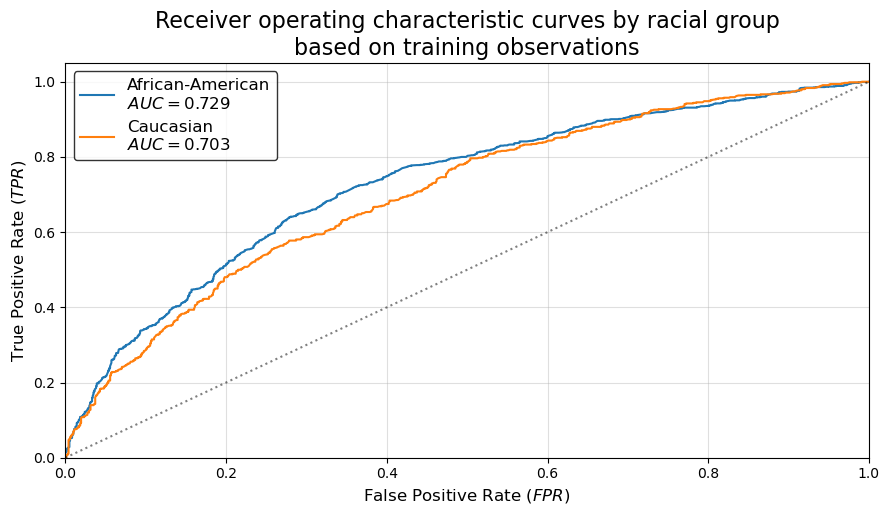

In [100]:
# generate predicted probabilities for training observations
preds_proba = logit_model_no_race.predict_proba(
    X_train_scaled_no_race
)[:,1]


# Generate AUC score separately for African-American and 
# Caucasian observations 
auc_score_aa = roc_auc_score(
    y_train[aa_idx_train], preds_proba[aa_idx_train]
)
auc_score_cc = roc_auc_score(
    y_train[cc_idx_train], preds_proba[cc_idx_train]
)

# Generate ROC curve values separately for African-American 
# and Caucasian observations
fpr_aa, tpr_aa, thresholds_aa = roc_curve(
    y_train[aa_idx_train], preds_proba[aa_idx_train]
)
fpr_cc, tpr_cc, thresholds_cc = roc_curve(
    y_train[cc_idx_train], preds_proba[cc_idx_train]
)


# Plot ROC curves
plt.figure(figsize=(9, 5.25))
plt.plot(
    fpr_aa,
    tpr_aa,
    label=f"African-American\n$AUC={auc_score_aa:.3f}$",
)
plt.plot(
    fpr_cc,
    tpr_cc,
    label=f"Caucasian\n$AUC={auc_score_cc:.3f}$",
)
plt.plot([0, 1], [0, 1], color="k", linestyle=":", alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate ($FPR$)", fontsize=12)
plt.ylabel("True Positive Rate ($TPR$)", fontsize=12)
plt.title(
    "Receiver operating characteristic curves by racial group\n"
    "based on training observations",
    fontsize=16
)
plt.legend(fontsize=12, edgecolor="k")
plt.grid(":", alpha=0.4)
plt.tight_layout()

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.1** The default threshold used for determining the classification metrics analyzed in Question 2 and Question 3 was $\hat{p}=0.5$.  Choose a new single threshold for the model from question 3 that will reduce the bias between these two racial groups as measured by the "Ratios of Error Rates" (as defined by the formulas shown in Question 2). Be certain to justify your choice and interpet how this threshold choice affects your model results.

**HINT:** There is no one correct answer here. However, to arrive at an answer you can support with an evidence-based justification, you will likely need to inspect the "Ratio of $FPR$", "Ratio of $FNR$", and accuracy trends across varying classification thresholds. There should be no need to refit your model from question 3 to accomplish this task. You can use the code provide to help make your decision, but again, feel free to create your own additional plots if you like.

</div>

_Points:_ 7

In [101]:
# Function to report required metrics by model and threshold
def evaluate_model_threshold(
    model, X_values, y_true, aa_idx, cc_idx, threshold
):
    """Generate metrics for model at a given threshold
    
    Generates a set of test metrics for an input model, including
    model accuracy and FPR and FNR for all observations and both
    African-American and Caucasian racial groups individually, as
    well as FPR and FNR ratios defined as FPR(AfAm)/FPR(Caucasion)
    and FNR(AfAm)/FNR(Caucasion)
    
    :param model: estimator, fitted scikit-learn classification
                  estimator such as LogisticRegression,
                  DecisionTreeClassifier, etc.
    :param X_values: np.ndarray, X matrix containing observations
                   for prediction and evaluation
    :param y_true: np.ndarray, true response classes
                   corresponding to each observation in the X
                   matrix
    :param aa_idx: np.ndarray, array of indices corresponding to
                   each African-American observation in the X
                   matrix
    :param cc_idx: np.ndarray, array of indices corresponding to
                   each Caucasion observation in the X matrix
    :param threshold: float, classification threshold, 0 to 1,
                      at which to evaluate model
    :returns: dict, resulting metrics including model accuracy,
              FPR, and FNR for all observations and both
              African-American and Caucasian racial groups, as
              well as FPR and FNR ratios
    """
    y_pred_proba = model.predict_proba(X_values)[:,1]
    y_preds = np.where(y_pred_proba >= threshold, 1, 0)
    model_accuracy = accuracy_score(y_preds, y_true)
    model_accuracy_afam = accuracy_score(
        y_preds[aa_idx], y_true[aa_idx]
    )
    model_accuracy_caucasian = accuracy_score(
        y_preds[cc_idx], y_true[cc_idx]
    )
    
    confusion_overall = dict(
        zip(
            ["tn","fp","fn","tp"],
            confusion_matrix(
                y_true, y_preds
            ).ravel(),
        )
    )

    confusion_afam = dict(
        zip(
            ["tn","fp","fn","tp"],
            confusion_matrix(
                y_true[aa_idx], y_preds[aa_idx]
            ).ravel(),
        )
    )
    confusion_caucasian = dict(
        zip(
            ["tn","fp","fn","tp"],
            confusion_matrix(
                y_true[cc_idx], y_preds[cc_idx]
            ).ravel(),
        )
    )

    fpr_all = (
        confusion_overall["fp"] / (
            confusion_overall["fp"] + confusion_overall["tn"]
        )
    )
    fnr_all = (
        confusion_overall["fn"] / (
            confusion_overall["fn"] + confusion_overall["tp"]
        )
    )

    
    fpr_afam = (
        confusion_afam["fp"] / (
            confusion_afam["fp"] + confusion_afam["tn"]
        )
    )
    fnr_afam = (
        confusion_afam["fn"] / (
            confusion_afam["fn"] + confusion_afam["tp"]
        )
    )

    fpr_caucasian = (
        confusion_caucasian["fp"] / (
            confusion_caucasian["fp"] + confusion_caucasian["tn"]
        )
    )
    fnr_caucasian = (
        confusion_caucasian["fn"] / (
            confusion_caucasian["fn"] + confusion_caucasian["tp"]
        )
    )
    
    with np.errstate(all="raise"):
        try:
            fpr_ratio = fpr_afam/fpr_caucasian
        except:
            fpr_ratio = 0

        try:
            fnr_ratio = fnr_afam/fnr_caucasian
        except:
            fnr_ratio = 0

    return dict(
        zip(
            [
                "threshold",
                "model_accuracy",
                "model_accuracy_afam",
                "model_accuracy_caucasian",
                "fpr_all",
                "fnr_all",
                "fpr_afam",
                "fnr_afam",
                "fpr_caucasian",
                "fnr_caucasian",
                "fpr_ratio",
                "fnr_ratio"
            ],
            [
                threshold,
                model_accuracy,
                model_accuracy_afam,
                model_accuracy_caucasian,
                fpr_all,
                fnr_all,
                fpr_afam,
                fnr_afam,
                fpr_caucasian,
                fnr_caucasian,
                fpr_ratio,
                fnr_ratio
            ],
        )
    )

In [102]:
# create list of 100 thresholds, p=[0, 1]
t_vals = np.arange(0, 1.01, 0.01)

# instantiate dict for storing results at each threshold
results_dict_train, results_dict_test = {}, {}

# generate train and test results at each threshold and store to dicts
for i, t in enumerate(t_vals):
    result_train = evaluate_model_threshold(
        logit_model_no_race,
        X_train_scaled_no_race,
        y_train, 
        aa_idx_train,
        cc_idx_train,
        threshold=t,
    )    
    result_test = evaluate_model_threshold(
        logit_model_no_race,
        X_test_scaled_no_race,
        y_test, 
        aa_idx_test,
        cc_idx_test,
        threshold=t,
    )    

    for key, val in result_train.items():
        # use dict.setdefault method to append val list for each
        # key. For more info on this use of the method...
        # see here: https://docs.python.org/3/library/
        #           stdtypes.html#dict.setdefault
        # and here: https://stackoverflow.com/a/26367880
        results_dict_train.setdefault(key, []).append(val)

    for key, val in result_test.items():
        results_dict_test.setdefault(key, []).append(val)


In [103]:
def plot_threshold(threshold):
    # instantiate lists for plotting axes
    key_list = ["fpr_ratio", "fnr_ratio", "model_accuracy"]
    title_list = ["$FPR$ ratio", "$FNR$ ratio", "Model accuracy"]

    # generate plot
    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    for i, (ax, key, title) in enumerate(
        zip(axes, key_list, title_list)
    ):
        ax.plot(results_dict_train["threshold"], results_dict_train[key])
        ax.set_ylabel(
            "Ratio" if "ratio" in title else "Accuracy",
            fontsize=12
        )
        ax.axvline(
            threshold,
            color="k",
            linestyle="--",
            label="Proposed threshold: $\hat{{p}}={:.2f}$".format(
                threshold
            ),
        )
        ax.axhline(
            results_dict_train[key][50],
            color="tab:red",
            linestyle=":",
            label="Metrics values at default threshold $\hat{{p}}=0.5$"
        )
        ax.set_title(title)
        ax.grid(":", alpha=0.4)
        if i==0:
            ax.legend(edgecolor="k", fontsize=11)
        if i==2:
            ax.set_xlabel("Classification threshold", fontsize=12)

    plt.suptitle(
        "Ratios of error rates "
        "$\left( \; \\frac{FPR(AA)}{FPR(CC)} \; and \; "
        "\\frac{FNR(AA)}{FNR(CC)} \; \\right)$ "
        "and model accuracy\nby classification threshold "
        "on the TRAINING data",
        fontsize=15,
    )
    plt.tight_layout()

    # print summary results
    group_list = ["Caucasian", "African-American"]
    var_list = ["caucasian", "afam"]
    threshold_indices = [int(threshold*1E+2)]*2

    print(
        "Naive model accuracy results, predicting all observations "
        "as Class 0\nbased on {:.4f} overall proportion Class 1 in "
        "training observations:\n\n\t\t\t\tTrain\t\tTEST\n"
        "\tCaucasian\t\t{:.4f}\t\t{:.4f}\n"
        "\tAfrican-American\t{:.4f}\t\t{:.4f}\n"
        "\tAll Observations\t{:.4f}\t\t{:.4f}\n".format(
            sum(y_train)/len(y_train),
            1-sum(y_train[cc_idx_train])/len(y_train[cc_idx_train]),
            1-sum(y_test[cc_idx_test])/len(y_test[cc_idx_test]),
            1-sum(y_train[aa_idx_train])/len(y_train[aa_idx_train]),
            1-sum(y_test[aa_idx_test])/len(y_test[aa_idx_test]),
            1-sum(y_train)/len(y_train),
            1-sum(y_test)/len(y_test),
        )
    )

    for group, var, t_idx in zip(
        group_list, var_list, threshold_indices
    ):
        print(
            "{} results with proposed threshold p={:.2f}:\n\n"
            "\t\t\tTrain\t\tTEST\n"
            "\tFPR\t\t{:.4f}\t\t{:.4f}\n"
            "\tFNR\t\t{:.4f}\t\t{:.4f}"
            "\n\tAccuracy\t{:.4f}\t\t{:.4f}\n"
            .format(
                group,
                results_dict_train['threshold'][t_idx],
                results_dict_train[f"fpr_{var}"][t_idx],
                results_dict_test[f"fpr_{var}"][t_idx],
                results_dict_train[f"fnr_{var}"][t_idx],
                results_dict_test[f"fnr_{var}"][t_idx],
                results_dict_train[f"model_accuracy_{var}"][t_idx],
                results_dict_test[f"model_accuracy_{var}"][t_idx],
            )
        )

    print(
        "Overall results (all racial groups) with proposed "
        "threshold p={:.2f}:\n\n\t\t\tTrain\t\tTEST\n"
        "\tFPR\t\t{:.4f}\t\t{:.4f}\n\tFNR\t\t{:.4f}\t\t{:.4f}"
        "\n\tAccuracy\t{:.4f}\t\t{:.4f}\n".format(
            results_dict_train['threshold'][t_idx],
            results_dict_train[f"fpr_all"][t_idx],
            results_dict_test[f"fpr_all"][t_idx],
            results_dict_train[f"fnr_all"][t_idx],
            results_dict_test[f"fnr_all"][t_idx],
            results_dict_train[f"model_accuracy"][t_idx],
            results_dict_test[f"model_accuracy"][t_idx],
        )
    )

_Although we entertained the notion of operationalizing Blackstone's Ratio by optimizing the threshold so $FNR = 10 FPR$,
doing so with only one threshold would require setting the threshold quite low for all defendants.
Instead, when only one ratio is available, it is prudent to maximize accuracy, even at the cost of fairness. Thus we
have set `threshold = .48` in order to maximize `model_accuracy`._

Naive model accuracy results, predicting all observations as Class 0
based on 0.4564 overall proportion Class 1 in training observations:

				Train		TEST
	Caucasian		0.6088		0.6105
	African-American	0.4744		0.4866
	All Observations	0.5436		0.5498

Caucasian results with proposed threshold p=0.48:

			Train		TEST
	FPR		0.2021		0.2296
	FNR		0.5167		0.4329
	Accuracy	0.6748		0.6912

African-American results with proposed threshold p=0.48:

			Train		TEST
	FPR		0.3386		0.3689
	FNR		0.3004		0.2761
	Accuracy	0.6815		0.6787

Overall results (all racial groups) with proposed threshold p=0.48:

			Train		TEST
	FPR		0.2597		0.2857
	FNR		0.3862		0.3597
	Accuracy	0.6826		0.6810



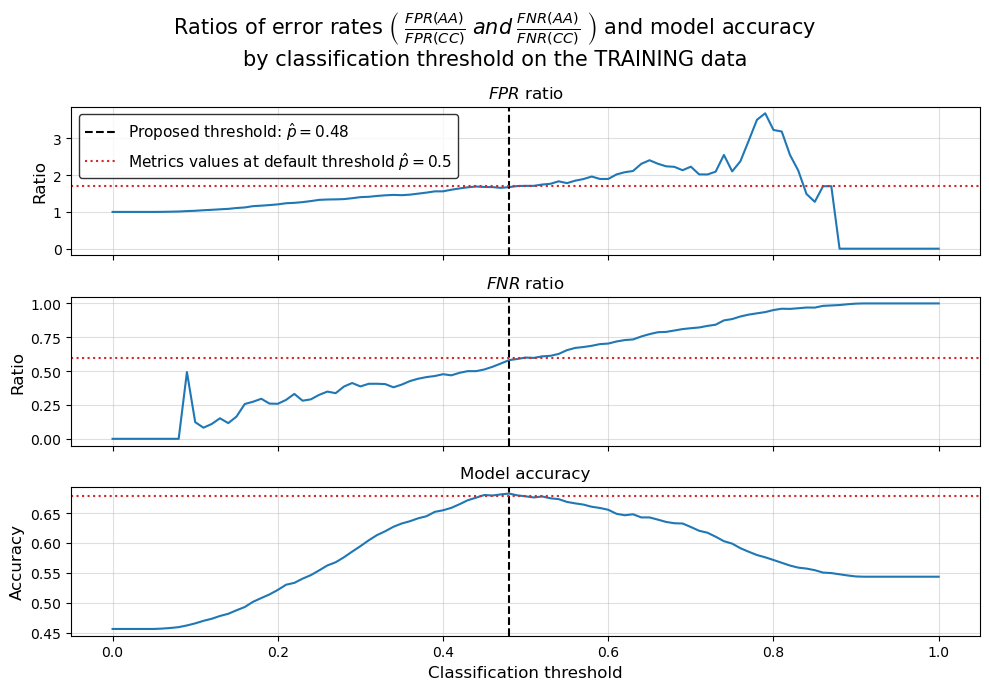

In [104]:
# set threshold for plotting and evaluating
threshold = .48
plot_threshold(threshold)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.2** A second approach to reducing bias is to use different thresholds for the different racial groups to better ensure that the individual groups have similar false positive and false negative rates.  Choose a pair of thresholds (one for the `African-American` group and one for the `Caucasian` group) that improves the group bias (while still taking accuracy into consideration). Be certain to justify your choices and interpet how these threshold choices affect your model results.

**HINT:** To arrive at an answer you can support with an evidence-based justification, you will likely need to inspect $FPR$, $FNR$, and accuracy trends across varying classification thresholds for each group (`African-American` and `Caucasian`) individually. There should be no need to refit your model from Question 3 to accomplish this task. Again, the plotting code provided can be used to help decide on a pair of thresholds.

</div>

_Points:_ 7

In [105]:
def plot_threshold_pair(t_cc, t_afam):
    # instantiate lists for plotting axes
    group_list = ["Caucasian", "African-American"]
    var_list = ["caucasian", "afam"]
    threshold_list = [t_cc, t_afam]


    # Generate plots
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4.5))
    plt.suptitle(
        '$FNR$, $FPR$, and accuracy trend and proposed "balanced"\n'
        "classification thresholds by racial group using "
        "the TRAINING data",
        fontsize=16,
        y=1,
    )

    for i, (group, var, threshold, ax) in enumerate(
        zip(group_list, var_list, threshold_list, axes)
    ):

        ax.plot(
            results_dict_train["threshold"],
            results_dict_train[f"fnr_{var}"],
            label="FNR",
        )
        ax.plot(
            results_dict_train["threshold"],
            results_dict_train[f"fpr_{var}"],
            label="FPR",
        )
        ax.plot(
            results_dict_train["threshold"],
            results_dict_train[f"model_accuracy_{var}"],
            "k-",
            label="Accuracy",
        )
        ax.axvline(
            threshold,
            color="k",
            linestyle="--",
            label="Proposed\nthreshold",
        )
        ax.set_title(f"{group} training observations", fontsize=14)
        ax.set_xlabel("Classification threshold", fontsize=12)
        ax.grid(":", alpha=0.4)

        if i==0:
            ax.legend(edgecolor="k", fontsize=12, loc=(.66, .11))
            ax.set_ylabel("Resulting metric value", fontsize=12)

    plt.tight_layout()

    # print summary results
    threshold_indices = [int(t_cc*1E+2), int(t_afam*1E+2)]

    for group, var, t_idx in zip(
        group_list, var_list, threshold_indices
    ):
        print(
            "{} results with proposed threshold p={:.2f}:\n\n"
            "\t\t\tTrain\t\tTEST\n"
            "\tFPR\t\t{:.4f}\t\t{:.4f}\n"
            "\tFNR\t\t{:.4f}\t\t{:.4f}"
            "\n\tAccuracy\t{:.4f}\t\t{:.4f}\n"
            .format(
                group,
                results_dict_train['threshold'][t_idx],
                results_dict_train[f"fpr_{var}"][t_idx],
                results_dict_test[f"fpr_{var}"][t_idx],
                results_dict_train[f"fnr_{var}"][t_idx],
                results_dict_test[f"fnr_{var}"][t_idx],
                results_dict_train[f"model_accuracy_{var}"][t_idx],
                results_dict_test[f"model_accuracy_{var}"][t_idx],
            )
        )

_We decided to employ Blackstone's ratio, and seek thresholds where $FNR \geq 10 FPR$ for each racial group.
Although the thresholds obtained through the training set do not quite satisfy Blackstone's ratio for the
test set, the ratios are still quite close:_

Caucasian results with proposed threshold p=0.63:

			Train		TEST
	FPR		0.0742		0.0895
	FNR		0.7553		0.6890
	Accuracy	0.6593		0.6770

African-American results with proposed threshold p=0.72:

			Train		TEST
	FPR		0.0631		0.0809
	FNR		0.7236		0.7362
	Accuracy	0.5898		0.5827



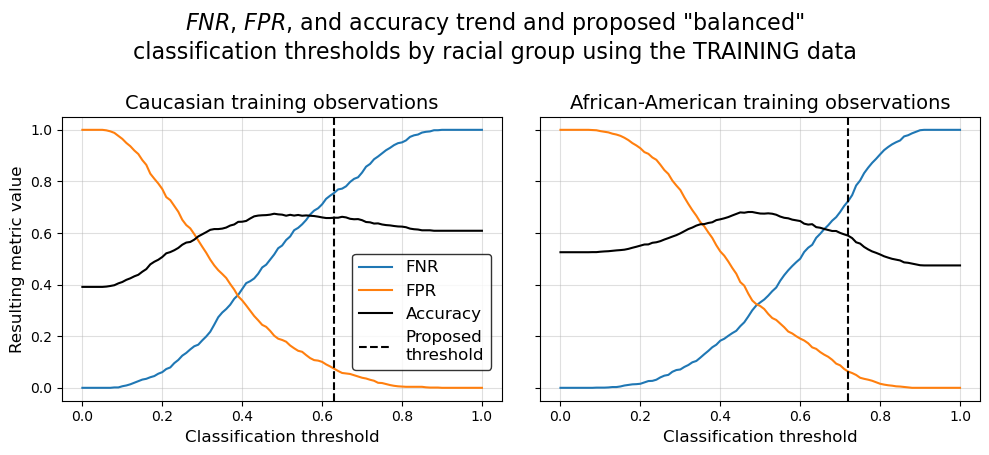

In [106]:
# identify balanced thresholds
results_df = pd.DataFrame(results_dict_train)
results_df["blackstone_afam"] = results_df.fnr_afam / results_df.fpr_afam > 10
results_df["blackstone_caucasian"] = results_df.fnr_caucasian / results_df.fpr_caucasian > 10

# thresholds for Caucasians 
t_cc = results_df.threshold[results_df.blackstone_caucasian == True].iloc[0]

# threshold for African Americans
t_afam = results_df.threshold[results_df.blackstone_afam == True].iloc[0]

plot_threshold_pair(t_cc, t_afam)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.3** Comment on [the fairness](<https://en.wikipedia.org/wiki/Fairness_(machine_learning)>) of the two methods in Question 4.1 and Question 4.2 from two different perspectives: the fairness of each group (called "group fairness") and the fairness for an individual defendant (called "individual fairness"). 

</div>

_Points:_ 10

_Question 4.1 allows for fairness across the group as the threshold is the same for both groups. However, it takes away from the fairness of the individual defendant as the data has shown a bias against African Americans. Question 4.2 allows for fairness for an individual because due to the bias against African Americans, the threshold is different for African Americans vs. Caucasians. However, this takes away from the fairness of the group because the same standards are not applied to everyone._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.4** Changing the thresholds can *reduce* bias between the two classes, but it can also affect model accuracy. We want our model to be **accurate** but also **fair**.  What can be done to balance these two criteria?  Write down your strategy to overcome this difficulty. Please limit your response to at most 150 words.  

</div>

_Points:_ 10

_Relying on Blackstone's ratio will sacrifice some accuracy in the model--particularly for African-American defendants. However, accuracy for Caucasians drops only slightly by setting their threshold at 0.63, suggesting another possible way to interpret the accuracy curves. Accuracy might be most useful as a guidepost to explore patterns and root causes underlying observable disparities._

_There is compelling evidence of racial disparity between African-Americans and Caucasians. That the Caucasian accuracy curve descends gently to the right suggests that when the system is fair, preferring mercy need not compromise accuracy too much._

_The failed attempt in Q3 to predict without using race demonstrates bias against African-Americans. Although a threshold of 0.72 might decrease accuracy, it helps solve the issue of racial bias. It is not always possible to be both fair and accurate. One or the other must be sacrificed, and for the current situation, we have chosen fairness._

<!-- END QUESTION -->

**This concludes HW7. Thank you!**

[Return to contents](#contents)